# JPEG Image Compression Algorithm in Python 
### Created by: Milan Sharma 

### JPEG Algorithm

The following sequence of steps lead to a Compressed JPEG Image:-

Compression :-

1. Block DCT on Original Image
2. Quantization of DCT Transformed Image.
3. Encoding.

Decompression:-

4. Decoding.
5. Dequantization of decoded image (DCT Transformed).
6. Inverse DCT on dequantized image to obtain JPEG Compressed Image.

### Post-processing of JPEG compressed images

The main goal of this project was to design an algorithm to improve the quality of JPEG images. The post-processing technique uses the knowledge of the transform coding process in order to constraint what the post-processed image will be. The following steps were taken: - 

1. Created functions to perform the forward and inverse block DCT-2D transforms as in JPEG image compression algorithm. 

2. Used Block DCT-2D (inverse of Inverse Block DCT-2D) to retrieve dequantized coefficients from a JPEG compressed image.

3. Defined a function to obtain Q matrix, given a quality factor and the quantization matrix.

4. Obtained possible range of values for original DCT coefficients, given dequantized coefficients and Q matrix.

5. Restored the decompressed image using denoise_tv_bregman and checked if the coefficients of the restored image were in the range of values obtained from step 4. 

6. Repeated step 5 until all the coefficients were in the desired range of values.

7. Evaluated the performance of this method using PSNR, MSE and SSIM image quality assessment measures and compared with the rate-distortion curves for JPEG and JPEG2000 image compression.

# Import Libraries

In [1]:
import os

In [2]:
import numpy as np
np.set_printoptions(suppress=True) #To display the flaot values in non-scientific notation

In [3]:
from matplotlib import pyplot as plt

In [4]:
from skimage.io import imread
from skimage.io import imsave

In [5]:
import glymur

In [6]:
from scipy.fftpack import dct, idct, dctn, idctn

In [7]:
from skimage import data
from skimage.restoration import denoise_tv_bregman, denoise_wavelet, denoise_tv_chambolle
from skimage.measure import compare_psnr, compare_ssim, compare_mse

# 1) Discrete Cosine Transform for 8x8 blocks

In [8]:
# Function to generate a Compressed JPEG Image given an Original Image and Quality factor

def get_JPEG_compressed_image(original_image, quality):
    imsave('test.jpeg', original_image, quality=quality)
    compressed_image = imread('test.jpeg')
    return compressed_image    

In [9]:
image = data.camera()
block = image[128:136,256:264]
compressed_image = get_JPEG_compressed_image(image,20)
compressed_block = compressed_image[128:136,256:264]

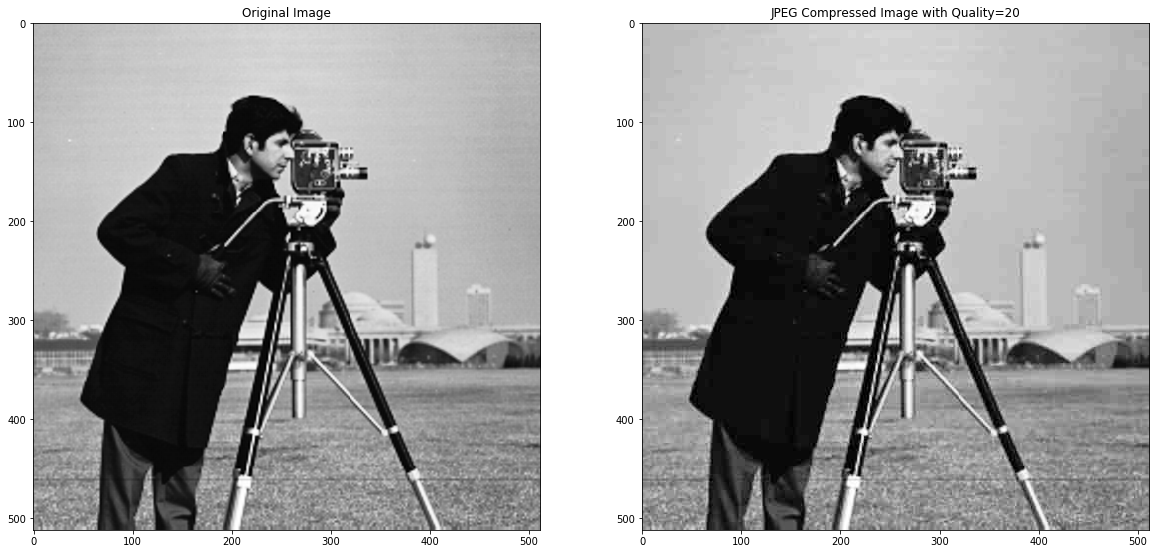

In [10]:
figure, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(image, cmap='Greys_r')
ax[0].set_title('Original Image')
ax[1].imshow(compressed_image, cmap="Greys_r")
ax[1].set_title('JPEG Compressed Image with Quality=20')
plt.show()

In [11]:
#Function to Apply 2D - DCT Transform on a block of an Image

def dct2(block):
    
    transformed_block = block.astype(float)
    
    for x in range(0,block.shape[0]): # 1D-DCT transform on Block Rows 
        row = transformed_block[x,:]
        row_dct = dct(row)
        transformed_block[x,:] = row_dct
        
    for y in range(0,block.shape[1]): # 1D-DCT transform on columns of the block obtained after applying 1D-DCT on rows
        col = transformed_block[:,y]
        col_dct = dct(col)
        transformed_block[:,y] = col_dct
        
    return transformed_block #returns 2D-DCT transformed block

In [12]:
#Function to Apply Inverse 2D - DCT Transform on a 2D-DCT transformed block

def idct2(block):
    
    transformed_block = block.astype(float)
    
    for y in range(0,block.shape[1]): #Inverse 1D-DCT transform on block columns
        col = transformed_block[:,y]
        col_idct = idct(col)
        transformed_block[:,y] = col_idct
        
    for x in range(0,block.shape[0]): #Inverse 1D-DCT transform on rows of the block obtained after applying Inverse 1D-DCT on columns 
        row = transformed_block[x,:]
        row_idct = idct(row)
        transformed_block[x,:] = row_idct
        
    return transformed_block

In [13]:
# Function to apply 2D DCT Operation on whole Image Block by Block

def block_dct2(image): 
    """
        Apply the 2D DCT transform block-by-block (8x8) on an image.
    """
    assert (image.shape[0] % 8 == 0) and (image.shape[1] % 8 == 0), 'Image size not a multiple of 8'
    
    blocks_list = []
    image_block_rows = np.vsplit(image,round(image.shape[0]/8)) #Row-wise splitting of image into groups, with each group having 8 rows
    
    for row in image_block_rows: #Splitting of each row group into 8x8 blocks 
        blocks = np.hsplit(row,round(image.shape[1]/8)) 
        blocks_list.append(blocks)
        
    
    dct_blocks_list = []
    for blocks in blocks_list: 
        dct_blocks = []
        for block in blocks: # Applying 2D-DCT Transform on each block
            dct_block = dct2(block)
            dct_blocks.append(dct_block)
            
        dct_blocks_list.append(dct_blocks)
            
        
    transformed_block_rows = []
    for dct_blocks in dct_blocks_list: # Stacking together of transformed blocks to obtain the transformed image
        transformed_row = np.hstack(dct_blocks)
        transformed_block_rows.append(transformed_row)
        
    transformed_image = np.vstack(transformed_block_rows)
    
    return transformed_image #returns Block DCT transformed image

In [14]:
# Function to apply Inverse 2D DCT Operation on transformed image Block by Block

def block_idct2(image):
    """
        Apply the inverse 2D DCT transform block-by-block (8x8) on an image.
    """
    # you can assume that the image shape is a multiple of 8
    assert (image.shape[0] % 8 == 0) and (image.shape[1] % 8 == 0), 'Image size not a multiple of 8'
    # your code

    blocks_list = []
    image_block_rows = np.vsplit(image,round(image.shape[0]/8)) #Row-wise splitting of transformed image into groups, with each group having 8 rows
    
    for row in image_block_rows: #Splitting of each row group into 8x8 blocks
        blocks = np.hsplit(row,round(image.shape[1]/8))
        blocks_list.append(blocks)
        
    
    idct_blocks_list = []
    for blocks in blocks_list: #Applying Inverse 2D-DCT Transform on each block
        idct_blocks = []
        for block in blocks:
            idct_block = idct2(block)
            idct_blocks.append(idct_block)
            
        idct_blocks_list.append(idct_blocks)
            
        
    transformed_block_rows = []  
    for idct_blocks in idct_blocks_list: #Stacking together of transformed blocks
        transformed_row = np.hstack(idct_blocks)
        transformed_block_rows.append(transformed_row)
        
    transformed_image = np.vstack(transformed_block_rows)
    
    return transformed_image #returns Inverse Block DCT transformed image

In [15]:
def test_roundtrip_dct(image):
    """
        Test function for round-trip between original image and transformed image.
    """
    transformed_image = block_dct2(image)
    image2 = block_idct2(transformed_image)//255
    np.testing.assert_almost_equal(image, image2,0)

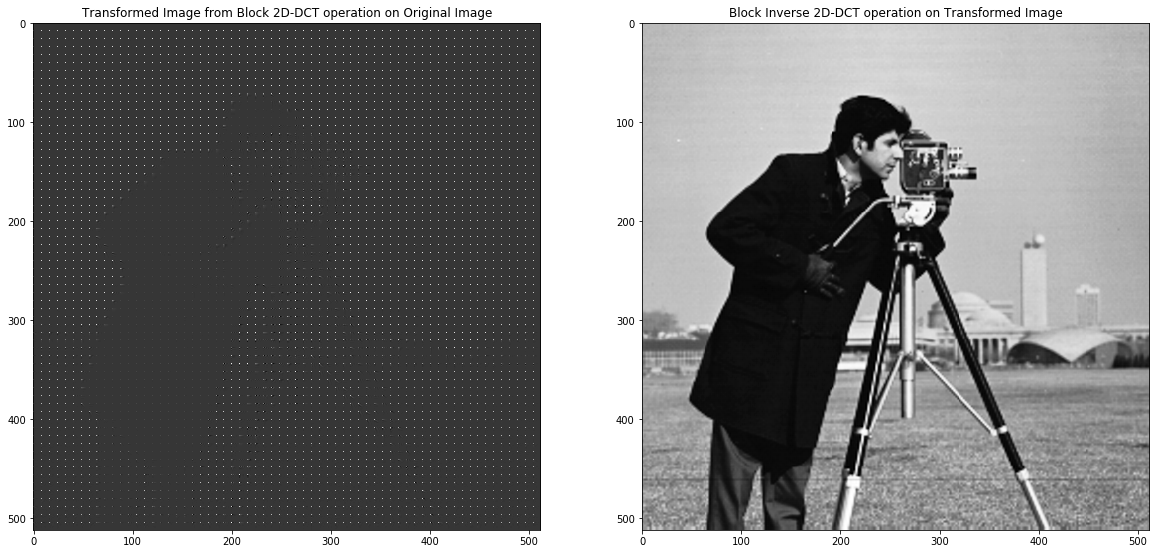

In [16]:
figure, ax = plt.subplots(1,2, figsize=(20,20))

image1 = block_dct2(image/255)
ax[0].imshow(image1, cmap="Greys_r")
ax[0].set_title('Transformed Image from Block 2D-DCT operation on Original Image')

image2 = block_idct2(image1)
ax[1].imshow(image2, cmap='Greys_r')
ax[1].set_title('Block Inverse 2D-DCT operation on Transformed Image')
plt.show()

In [17]:
test_roundtrip_dct(image) #Round Trip Testing of block_dct2 and block_idct2

What are the dequantized transformed values given a JPEG compressed image?

The following sequence of steps lead to a Compressed JPEG Image:-

Compression :-    
1. Block DCT on Original Image 
2. Quantization of DCT Transformed Image
3. Encoding

Decompression:-
4. Decoding
5. Dequantization of decoded image (DCT Transformed)
6. Inverse DCT on dequantized image to obtain JPEG Compressed Image

From the last step of the above sequence it can be observed that given a JPEG Compressed Image, the dequantized coefficents can be obtained 
by applying Block DCT transform (i.e. inverse of Inverse Block DCT)

In [18]:
dequantized_coeffs = block_dct2(compressed_image/255) #Dequantized Coefficients from the JPEG Compressed Image

# 2) Constraint on JPEG coefficients

The quantization matrix for the luminance channel in JPEG compression is defined below:-

In [19]:
QM = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
             (12, 12, 14, 19, 26, 58, 60, 55),
             (14, 13, 16, 24, 40, 57, 69, 56),
             (14, 17, 22, 29, 51, 87, 80, 62),
             (18, 22, 37, 56, 68, 109, 103, 77),
             (24, 35, 55, 64, 81, 104, 113, 92),
             (49, 64, 78, 87, 103, 121, 120, 101),
             (72, 92, 95, 98, 112, 100, 103, 99)))

In [20]:
def quality_factor(QM, quality=50):
    """
       The quantization matrix is multiplied by a quality factor defined by a quality value between 1 and 100. 
    """
    if quality<=50:
        r = 50/quality
    else:
        r = 2-quality/50
    QMp = r*QM
    QMp[QMp<1] = 1
    return QMp

In [21]:
Q = quality_factor(QM, 20)
Q

array([[ 40. ,  27.5,  25. ,  40. ,  60. , 100. , 127.5, 152.5],
       [ 30. ,  30. ,  35. ,  47.5,  65. , 145. , 150. , 137.5],
       [ 35. ,  32.5,  40. ,  60. , 100. , 142.5, 172.5, 140. ],
       [ 35. ,  42.5,  55. ,  72.5, 127.5, 217.5, 200. , 155. ],
       [ 45. ,  55. ,  92.5, 140. , 170. , 272.5, 257.5, 192.5],
       [ 60. ,  87.5, 137.5, 160. , 202.5, 260. , 282.5, 230. ],
       [122.5, 160. , 195. , 217.5, 257.5, 302.5, 300. , 252.5],
       [180. , 230. , 237.5, 245. , 280. , 250. , 257.5, 247.5]])

Defined a Rounding Function below since the NumPy's inbuilt round() function does not rounds the input to nearest integer as per Standard Convention.    It is illustarted with an example below:-   

In [22]:
a = np.array([1.5, 2.5, 3.5, 4.5])
rounded_a = np.round(a)
print(rounded_a)

[2. 2. 4. 4.]


In [23]:
def rounding_function(array):
    rounded_array = np.zeros((array.shape))
    
    for i,number in np.ndenumerate(array):
        lower_int = int(number)
        if number > 0:
            middle_num = lower_int + 0.5
            if number < middle_num:
                rounded_array[i] = lower_int
            else:
                rounded_array[i] = lower_int +1
                
        elif number < 0:
            middle_num = lower_int - 0.5
            if number < middle_num:
                rounded_array[i] = lower_int -1
            else:
                rounded_array[i] = lower_int
                
        else:
            rounded_array[i] = 0
            
    return rounded_array       

The above defined rounding function, rounds the input to nearest integer as per Standard Convention. Example Below:-

In [24]:
a = np.array([1.5, 2.5, 3.5, 4.5])
rounded_a = rounding_function(a)
print(rounded_a)

[2. 3. 4. 5.]


In [25]:
#Function to Quantize the DCT Coefficients given a Quantization Matrix

def quantized_image(Q, dct_transformed_image): 
    image = dct_transformed_image
    blocks_list = []
    image_block_rows = np.vsplit(image,round(image.shape[0]/8)) #Row-wise splitting of transformed image into groups, with each group having 8 rows
    
    for row in image_block_rows: #Splitting of each row group into 8x8 blocks
        blocks = np.hsplit(row,round(image.shape[1]/8))  
        blocks_list.append(blocks)
        
    quantized_blocks_list = []
    for blocks in blocks_list:
        quantized_blocks = []
        for block in blocks:
            quantized_block = rounding_function(block/Q) #Quantization of Block
            quantized_blocks.append(quantized_block)
            
        quantized_blocks_list.append(quantized_blocks)
        
    quantized_block_rows = []
    for quantized_blocks in quantized_blocks_list: #Stacking together of quantized blocks
        quantized_row = np.hstack(quantized_blocks)
        quantized_block_rows.append(quantized_row)
        
    quantized_image = np.vstack(quantized_block_rows)
    
    return quantized_image #returns quantized coefficients

In [26]:
#Function to dequantize the quantized DCT Coefficients given a Quantization Matrix

def dequantized_image(Q, quantized_coefficients):
    image = quantized_coefficients
    blocks_list = []
    image_block_rows = np.vsplit(image,round(image.shape[0]/8)) #Row-wise splitting of transformed image into groups, with each group having 8 rows
    
    
    for row in image_block_rows: #Splitting of each row group into 8x8 blocks
        blocks = np.hsplit(row,round(image.shape[1]/8))
        blocks_list.append(blocks)
        
    dequantized_blocks_list = []
    for blocks in blocks_list:
        dequantized_blocks = []
        for block in blocks: 
            dequantized_block = np.multiply(block,Q) #De-quantization of Block
            dequantized_blocks.append(dequantized_block)
            
        dequantized_blocks_list.append(dequantized_blocks)
        
    dequantized_block_rows = []
    for dequantized_blocks in dequantized_blocks_list: #Stacking together of dequantized blocks
        dequantized_row = np.hstack(dequantized_blocks)
        dequantized_block_rows.append(dequantized_row)
        
    dequantized_image = np.vstack(dequantized_block_rows)
    
    return dequantized_image #returns dequantized coefficients

### Effect of quantization and dequantization steps on a scalar value

The process of  quantization and dequantization is lossy in general and it is also main reason behind distortion (compression artifacts) occuring in JPEG compressed images.

The effect of quantization on a scalar value can be shown as following:-

Consider a scalar value, X = 7.8
Quantization Step, Q = 5

Quantized Value of X, Xq = Round(X/Q) = Round(1.56) = 2

Dequantized Value of Xq, Xdq = Xq*Q = 2 x 5 = 10

Here it can be observed that 
Original Value of X = 7.8 where as Value after dequantization Xdq = 10

This is the kind of loss that occurs in JPEG Compression during Quantization and Dequantization Process.

### Possible range of values for Original DCT coefficient given Dequantized Coefficient and Quantization step

Given a Dequantized Coefficient Xdq = 10
Quantization Step Q = 5

Quantized Coefficient Value Xq = Xdq/Q = 10/5 = 2

Also Xq = Round(X/Q), where X is Original Coefficient Value, 
Therefore X/Q can have any value in the range [1.5,2.5) since all the values in this range will round to 2
                                               
Or in terms of X:  7.5 <= X < 12.5
                                               
In general given a dequantized coefficient Xdq and quantization step Q, the possible range of values for original coefficient X
                                               
                                        (Xdq/Q - 0.5)Q    <=  X  < (Xdq/Q + 0.5)Q

Using the ablove generalization, function range_of_values is defined which returns a list of two arrays:-
1. lower_bounds
2. upper_bounds

for a given array of dequantized coefficients and quantization matrix.

For each dequantized coefficient value, lower_bounds consist of corresponding lower bound value of the constraint for where as upper_bound consist of upper bound value of the constraint for original value of dequantized coefficient.

In [27]:
def range_of_values(dequantized_coefficients, QM):
    
    bounds = []
    
    image = dequantized_coefficients
    
    blocks_list = []
    image_block_rows = np.vsplit(image,round(image.shape[0]/8))
    
    for row in image_block_rows:
        blocks = np.hsplit(row,round(image.shape[1]/8))
        blocks_list.append(blocks)
        
    lower_bound_blocks_list = []
    upper_bound_blocks_list = []
    
    for blocks in blocks_list:
        lower_bound_blocks = []
        upper_bound_blocks = []
        for block in blocks:
            quantized_block = rounding_function(block/QM)
            lower_bound_block = np.multiply((quantized_block - 0.5),QM)
            upper_bound_block = np.multiply((quantized_block + 0.5),QM)
            lower_bound_blocks.append(lower_bound_block)
            upper_bound_blocks.append(upper_bound_block)
            
        lower_bound_blocks_list.append(lower_bound_blocks)
        upper_bound_blocks_list.append(upper_bound_blocks)
        
    lower_bound_block_rows = []
    
    for lower_bound_blocks in lower_bound_blocks_list:
        lower_bound_row = np.hstack(lower_bound_blocks)
        lower_bound_block_rows.append(lower_bound_row)
        
    upper_bound_block_rows = []
    
    for upper_bound_blocks in upper_bound_blocks_list:
        upper_bound_row = np.hstack(upper_bound_blocks)
        upper_bound_block_rows.append(upper_bound_row)
        
    lower_bounds = np.vstack(lower_bound_block_rows)
    upper_bounds = np.vstack(upper_bound_block_rows)
    
    
    bounds = [lower_bounds,upper_bounds]
    
    return bounds

The function defined below projects the input coefficients onto the constraint defined by range_of_values and returns projected coefficients

In [28]:
def project_quantized(coefficients,bounds):
    
    projected_coefficients = np.zeros((coefficients.shape))
    
    lower_bounds = bounds[0]
    upper_bounds = bounds[1]
    
    for i,coefficient in np.ndenumerate(coefficients):
        
        if lower_bounds[i] <= coefficient and coefficient < upper_bounds[i]: #if the coefficient lies within the constraint then projected value = coefficient value
            projected_coefficients[i] = coefficient
            
        elif coefficient >= upper_bounds[i]: #if coefficient value exceeds the upper bound then projected value = upper bound - 0.00001 (since upper bound is not itself included in the constraint)
            projected_coefficients[i] = upper_bounds[i] - 0.00001
            
        elif coefficient < lower_bounds[i]: #if coefficient value is lower than lower bound then projected value = lower bound
            projected_coefficients[i] = lower_bounds[i]
            
    return projected_coefficients

In [29]:
def test_project_quantized(coefficients, bounds):
    """
        Test if the projection project_quantized is really a project by checking if P(X)=P(P(X))
    """
    projected_coefficients = project_quantized(coefficients, bounds)
    projected_coefficients2 = project_quantized(projected_coefficients, bounds)
    np.testing.assert_almost_equal(projected_coefficients, projected_coefficients2,3)

In [30]:
bounds = range_of_values(dequantized_coeffs, Q)

In [31]:
lower_bounds = bounds[0]
lower_bounds

array([[ 140.  ,  -13.75,  -12.5 , ...,  -50.  ,  -63.75,  -76.25],
       [ -15.  ,  -15.  ,  -17.5 , ...,  -72.5 ,  -75.  ,  -68.75],
       [ -17.5 ,  -16.25,  -20.  , ...,  -71.25,  -86.25,  -70.  ],
       ...,
       [ -30.  ,  -43.75,  -68.75, ..., -130.  , -141.25, -115.  ],
       [ -61.25,  -80.  ,  -97.5 , ..., -151.25, -150.  , -126.25],
       [ -90.  , -115.  , -118.75, ..., -125.  , -128.75, -123.75]])

In [32]:
upper_bounds = bounds[1]
upper_bounds

array([[180.  ,  13.75,  12.5 , ...,  50.  ,  63.75,  76.25],
       [ 15.  ,  15.  ,  17.5 , ...,  72.5 ,  75.  ,  68.75],
       [ 17.5 ,  16.25,  20.  , ...,  71.25,  86.25,  70.  ],
       ...,
       [ 30.  ,  43.75,  68.75, ..., 130.  , 141.25, 115.  ],
       [ 61.25,  80.  ,  97.5 , ..., 151.25, 150.  , 126.25],
       [ 90.  , 115.  , 118.75, ..., 125.  , 128.75, 123.75]])

In [33]:
test_project_quantized(dequantized_coeffs,bounds)

# 3. Restoration

In [34]:
# This function uses denoise_tv_bregman restoration method from skimage
# Inputs are Noisy Image, Weight term for denoise_tv_bregman
# Returns a list containing Restored Image and Restored Image Block DCT coefficients

def get_restored_image_and_coefficients(image,weight):
    
    restored = []  
    restored_image = denoise_tv_bregman(image, weight=weight, max_iter=100, eps=0.001, isotropic=True)  
    restored_coeffs = block_dct2(restored_image)
    restored = [restored_image,restored_coeffs]
    
    return restored    

In [35]:
restored1 = get_restored_image_and_coefficients(compressed_image/255,70)
restored2 = get_restored_image_and_coefficients(compressed_image/255,1)

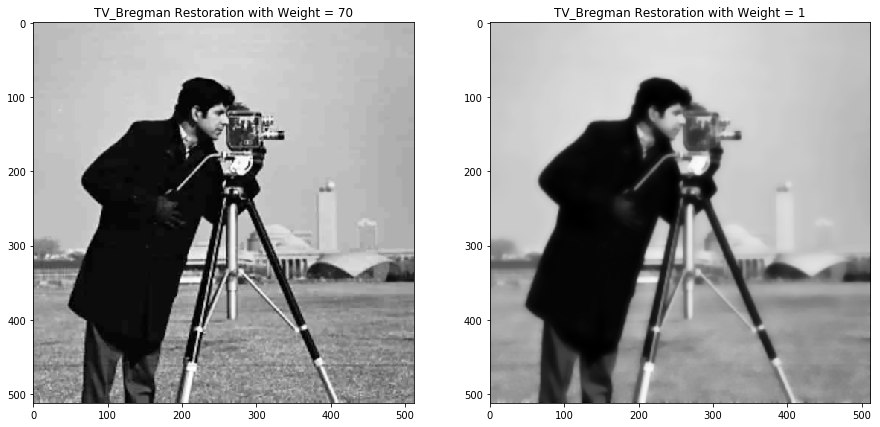

In [36]:
figsize, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(restored1[0], cmap='Greys_r')
ax[0].set_title("TV_Bregman Restoration with Weight = 70")
ax[1].imshow(restored2[0], cmap='Greys_r')
ax[1].set_title("TV_Bregman Restoration with Weight = 1")
plt.show()

Increasing the weight term reduces the amount of restoration but preserves similarity to the original image 

# 4. Iterative Method

In [37]:
#This function checks if input coefficient values are in the specifcied bounds
#Returns True if all coefficient values are within bounds
#Returns False if all coefficient values are not within bounds

def check_coefficients_in_bounds(coefficients,bounds):
    
    lower_bounds = bounds[0]
    upper_bounds = bounds[1]
       
    lower_check = not(False in (lower_bounds <= coefficients))
    upper_check = not(False in (coefficients < upper_bounds))
        
    if(lower_check and upper_check):
        check =  True
    else:
        check =  False
        
    return check

In [38]:
#This function checks if input coefficient values are in the specifcied bounds
#Returns the number of coefficient values which are out of bounds

def get_out_of_bounds(coefficients,bounds):
    
    lower_bounds = bounds[0]
    upper_bounds = bounds[1]
    indices = []
    
    for i,coeff in np.ndenumerate(coefficients):
        if lower_bounds[i] <= coeff and coeff < upper_bounds[i]:
            continue
        else:
            indices.append(i)
            
    return len(indices)

In [39]:
check_coefficients_in_bounds(restored2[1],bounds) 

False

In [40]:
get_out_of_bounds(restored2[1],bounds)

792

This shows that some DCT coefficents of restored image lie out of bounds 

### Iterative Method

The function below is an iterative denoising method for JPEG Compressed Images. It works in following sequence:-

Inputs: Compressed Images, Quality Factor

1. Calculate Quality Matrix using QM and Quality Factor
2. Obtain Dequantized Coefficients from Compressed Image using Block DCT
3. Obtain Constraints using range_of_values (dequantized_coeffs, Q)
4. Restore Image
5. Check if the number of restored image coefficients out of constraint decreased in current iteration (skip for 1st iteration) 
6. Project Restored Image Coefficients onto the Constraint
7. Obtain Restored Image by applying Inverse Block DCT transform on projected coefficients
8. Goto 4 if check from Step 5 is True else End

Return Restored Image, Number of Iterations

In [41]:
def iterative_denoising(compressed_image, Quality_Factor):
    
    Q = quality_factor(QM, quality=Quality_Factor) #Obtain Quality Matrix
    
    image_r = compressed_image
    out_of_bounds = [] #List to store number of restored coefficients out of bounds during each iteration
    iterations = 0
    
    
    dequantized_coeffs = block_dct2(image_r/255) #Obtain Dequantized Coefficients
    bounds = range_of_values(dequantized_coeffs, Q) # Obtain Constraints
    

    while True:
        
        iterations = iterations + 1
        
        weight = Quality_Factor + 30 #weight for image restoration (Higher weight for less distored images i.e images with higher quality)
        
        restored = get_restored_image_and_coefficients(image_r/255, weight) #Restore Image
        restored_image = restored[0]
        restored_coeffs = restored[1]
    
        out_of_bounds.append(get_out_of_bounds(restored_coeffs, bounds)) #obtain number of coefficients out of bounds
        
        if iterations == 1:
            projected_coeffs = project_quantized(restored_coeffs,bounds)
            projected_image =  block_idct2(projected_coeffs)
            image_r = projected_image.astype(np.uint8)
            
        else:
            if(out_of_bounds[-1] <= out_of_bounds[-2]): #Check if number of out of bounds coefficients are decreasing
                projected_coeffs = project_quantized(restored_coeffs,bounds) #Project Coefficients
                projected_image =  block_idct2(projected_coeffs) # Obtain Image by Inverse DCT of Projected Coefficients
                image_r = projected_image.astype(np.uint8)
                
            else:
                break
                
        
    return  image_r, iterations-1

In [42]:
compressed_image = get_JPEG_compressed_image(image,30)

In [43]:
restored_img, iterations = iterative_denoising(compressed_image,30)
iterations

1

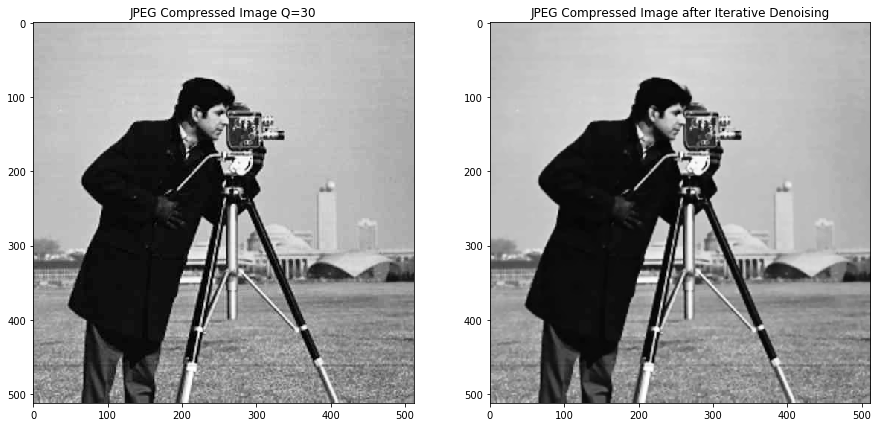

In [44]:
figure, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(compressed_image, cmap='Greys_r')
ax[0].set_title('JPEG Compressed Image Q=30')
ax[1].imshow(restored_img, cmap='Greys_r')
ax[1].set_title('JPEG Compressed Image after Iterative Denoising')
plt.show()

# 5. Performance Comparison

In [45]:
Quality_Factors = list(range(95,0,-10))
Quality_Factors

[95, 85, 75, 65, 55, 45, 35, 25, 15, 5]

In [46]:
original_image = data.camera()

In [47]:
#Generate JPEG Compressed Images and Corresponding MSE, SSIM and PSNR values (w.r.t) Original Image

JPEG_MSE = []
JPEG_SSIM = []
JPEG_PSNR = []
JPEG_CR = []
JPEG_Images = []

for factor in Quality_Factors:
    imsave('test.jpeg', original_image, quality=factor)
    compressed_image = imread('test.jpeg')
    
    compressed_image_size = os.path.getsize('test.jpeg')
    compression_ratio = compressed_image.shape[0]*compressed_image.shape[1]/compressed_image_size
    
    
    mse = compare_mse(original_image,compressed_image)
    ssim = compare_ssim(original_image,compressed_image)
    psnr = compare_psnr(original_image,compressed_image)
    
    JPEG_Images.append(compressed_image)
    JPEG_MSE.append(mse)
    JPEG_SSIM.append(ssim)
    JPEG_PSNR.append(psnr)
    JPEG_CR.append(compression_ratio)

In [48]:
#Generate JPEG2000 Compressed Images and Corresponding MSE, SSIM and PSNR values (w.r.t) Original Image

JPEG2k_MSE = []
JPEG2k_SSIM = []
JPEG2k_PSNR = []
JPEG2k_Images = []

for CR in JPEG_CR:
    jp2 = glymur.Jp2k('test.jp2', data=original_image, cratios=[CR])
    compressed_image = jp2[:]
      
    mse = compare_mse(original_image,compressed_image)
    ssim = compare_ssim(original_image,compressed_image)
    psnr = compare_psnr(original_image,compressed_image)
    
    JPEG2k_Images.append(compressed_image)
    JPEG2k_MSE.append(mse)
    JPEG2k_SSIM.append(ssim)
    JPEG2k_PSNR.append(psnr)

In [49]:
#Generate JPEG + Total Variation Denoised Compressed Images and Corresponding MSE, SSIM and PSNR values (w.r.t) Original Image

# will take a few seconds to run

JPEG_TV_MSE = []
JPEG_TV_SSIM = []
JPEG_TV_PSNR = []
JPEG_TV_Images = []

for i,image in enumerate(JPEG_Images):
    
    compressed_image =  iterative_denoising(image, Quality_Factors[i])[0] #iterative denoising
    compressed_image = compressed_image.astype(np.uint8)
    
    mse = compare_mse(original_image,compressed_image)
    ssim = compare_ssim(original_image,compressed_image)
    psnr = compare_psnr(original_image,compressed_image)
    
    JPEG_TV_Images.append(compressed_image)
    JPEG_TV_MSE.append(mse)
    JPEG_TV_SSIM.append(ssim)
    JPEG_TV_PSNR.append(psnr)

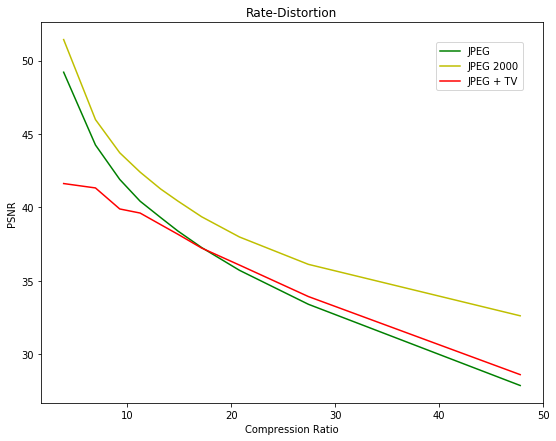

In [50]:
figure,ax = plt.subplots(1,1, figsize=(9,7))
ax.set_title('Rate-Distortion')
ax.plot(JPEG_CR,JPEG_PSNR, 'g', label='JPEG')
ax.set_xlabel('Compression Ratio')
ax.plot(JPEG_CR,JPEG2k_PSNR , 'y' , label='JPEG 2000')
ax.set_ylabel('PSNR')
ax.plot(JPEG_CR,JPEG_TV_PSNR , 'r' , label='JPEG + TV')
plt.legend(bbox_to_anchor=(1,1), loc=1, borderaxespad=2)
plt.show()

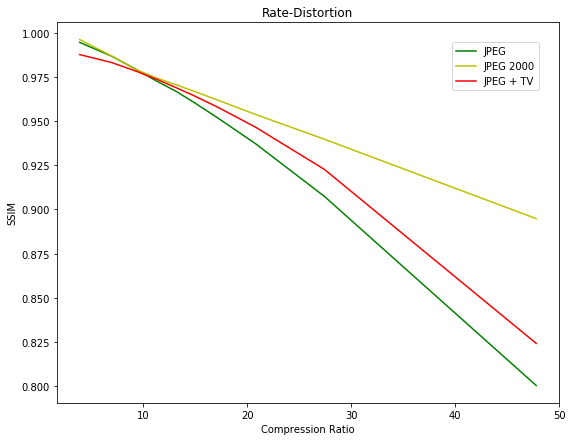

In [51]:
figure,ax = plt.subplots(1,1, figsize=(9,7))
ax.set_title('Rate-Distortion')
ax.plot(JPEG_CR,JPEG_SSIM, 'g', label='JPEG')
ax.set_xlabel('Compression Ratio')
ax.plot(JPEG_CR,JPEG2k_SSIM , 'y' , label='JPEG 2000')
ax.set_ylabel('SSIM')
ax.plot(JPEG_CR,JPEG_TV_SSIM , 'r' , label='JPEG + TV')
plt.legend(bbox_to_anchor=(1,1), loc=1, borderaxespad=2)
plt.show()

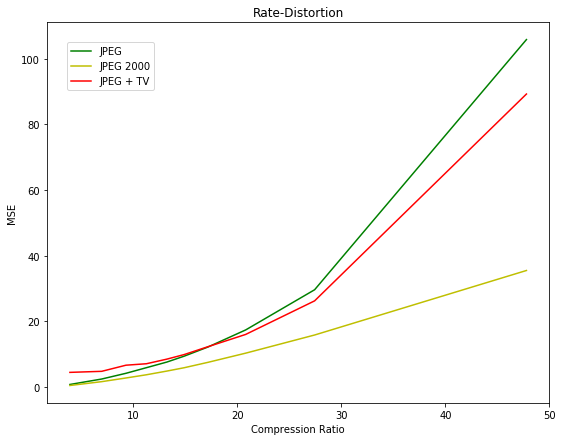

In [52]:
figure,ax = plt.subplots(1,1, figsize=(9,7))
ax.set_title('Rate-Distortion')
ax.plot(JPEG_CR,JPEG_MSE, 'g', label='JPEG')
ax.set_xlabel('Compression Ratio')
ax.plot(JPEG_CR,JPEG2k_MSE, 'y' , label='JPEG 2000')
ax.set_ylabel('MSE')
ax.plot(JPEG_CR,JPEG_TV_MSE, 'r' , label='JPEG + TV')
plt.legend(bbox_to_anchor=(0,1), loc=2, borderaxespad=2)
plt.show()

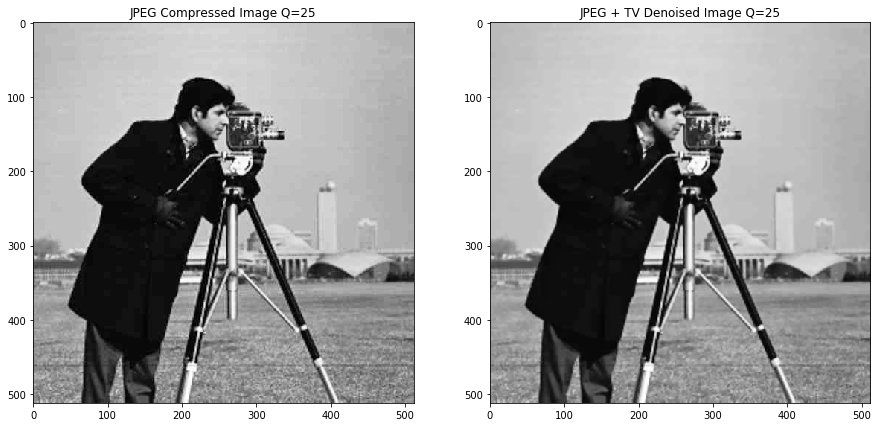

In [53]:
figure, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(JPEG_Images[-3], cmap='Greys_r')
ax[0].set_title('JPEG Compressed Image Q=25')
ax[1].imshow(JPEG_TV_Images[-3], cmap='Greys_r')
ax[1].set_title('JPEG + TV Denoised Image Q=25')
plt.show()